In [95]:
# 1-1. 패키지 호출
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow.keras import layers

print("Tensorflow Version: %s" % tf.__version__)
print("Keras Version: %s" %tf.keras.__version__)

Tensorflow Version: 2.2.0
Keras Version: 2.3.0-tf


In [96]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [97]:
tf.test.gpu_device_name()
tf.config.experimental.list_physical_devices(device_type='GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [98]:
# 2-1. CSV 데이터 읽어오기
import pandas as pd

data = pd.read_csv('C:/Users/tqkqh/Documents/GitHub/Korean_GAN/pre/train/train_gen.csv').astype('float32')
data.head()

0      1      2      3      4      5      6      7      8      9  ...  \
0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  ...   
1  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  ...   
2  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  ...   
3  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  ...   
4  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  ...   

    1014   1015   1016   1017   1018   1019   1020   1021   1022   1023  
0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  
1  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  
2  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  
3  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  
4  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  

[5 rows x 1024 columns]

In [99]:
# 2-2. 3D Vector 변환

width, height, channel = 32, 32, 1 # 이미지 사이즈 32*32 pixel

X = data.values
X = X.reshape((X.shape[0], width, height, channel))

In [100]:
# 2-3. Image Pixel Normalization [0,255] -> [-1,1] 

X = (X - 127.5) / 127.5 

print(X[0])

[[[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 ...

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]]


In [101]:
X[0].shape

(32, 32, 1)

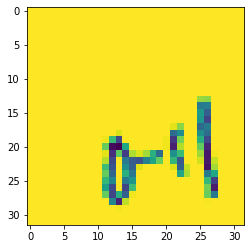

In [102]:
plt.imshow(X[1])

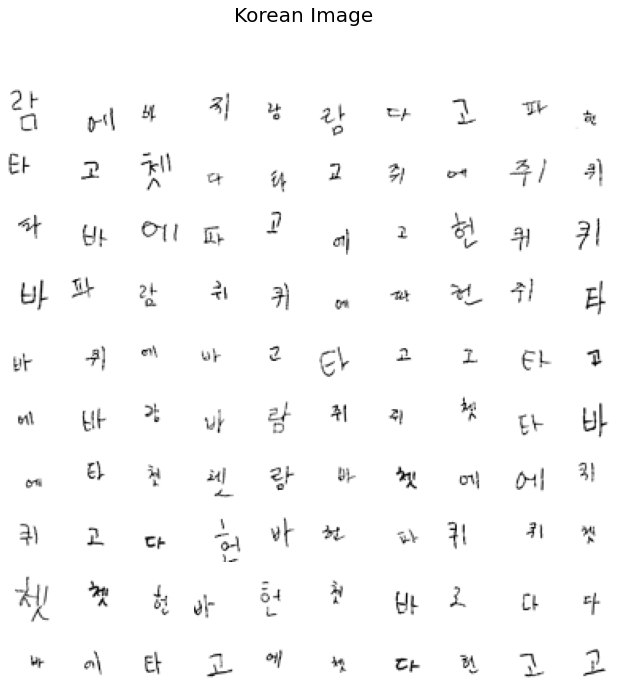

In [103]:
# 2-4. 한글 이미지 시각화
 
plt.figure(figsize=(11,11))
    
i = 1
for image in X:
    plt.subplot(10, 10, i) #(10*10) 총 100칸
    image = image.reshape(width, height)
    plt.imshow(image, cmap='gray') # 흑백 이미지
    plt.axis('off')
    i+=1
    if i > 100: break

plt.suptitle("Korean Image", fontsize = 20)
plt.show()

In [104]:
# 2-5. 학습 데이터 batch 준비

BATCH_SIZE = 64

# Input dataset + image randum shuffle
train_dataset = tf.data.Dataset.from_tensor_slices(X).shuffle(X.shape[0]).batch(BATCH_SIZE)

print(train_dataset)

<BatchDataset shapes: (None, 32, 32, 1), types: tf.float32>


In [105]:
# 3-1. Generator 모델 네트워크 구성

def build_generator_model():
    model = tf.keras.Sequential() # Keras 모델 생성

    model.add(layers.Dense(1024, input_dim=100, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(8*8*128, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Reshape (8*8)
    model.add(layers.Reshape((8, 8, 128)))  
    
    model.add(layers.Conv2DTranspose(128, (5, 5), 
                                    strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization()) 
    model.add(layers.LeakyReLU())
    
    # (8*8) -> (16*16)
    model.add(layers.Conv2DTranspose(64, (5, 5), 
                                    strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # (16*16) -> (32*32)
    model.add(layers.Conv2DTranspose(1, (5, 5), 
                                    strides=(2, 2), padding='same', activation='tanh'))
    assert model.output_shape == (None, 32, 32, 1)

    return model

In [106]:
# 3-2. 생성자 모델 생성

generator = build_generator_model()
generator.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 1024)              102400    
_________________________________________________________________
batch_normalization_12 (Batc (None, 1024)              4096      
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 8192)              8388608   
_________________________________________________________________
batch_normalization_13 (Batc (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 8, 8, 128)        

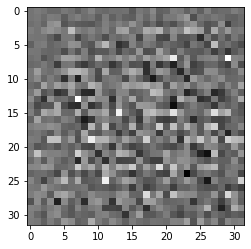

In [107]:
# 3-3. 학습되지 않은 생성자 모델이 만든 이미지

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [108]:
# 4-1. Discriminator 모델 네트워크 구성

def build_discriminator_model():

    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, (5, 5), strides=2, padding='same', input_shape=[32, 32, 1])) # input image size
    model.add(layers.LeakyReLU(0.1))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, (5, 5), strides=2, padding='same'))
    model.add(layers.LeakyReLU(0.1))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(0.1))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(0.1))
    model.add(layers.Dropout(0.25))

    model.add(layers.Dense(1))
    
    return model

In [109]:
# 4-2. 판별자 모델 생성

discriminator = build_discriminator_model()
discriminator.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 16, 16, 64)        1664      
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)              

In [110]:
# 4-3. 학습되지 않은 판별자의 결과

predicted = discriminator(generated_image)
print(predicted)

tf.Tensor([[0.00450559]], shape=(1, 1), dtype=float32)


In [111]:
# 5-1. Optimizer 생성

# 생성자용
generator_optimizer = tf.keras.optimizers.Adam(2e-4)
# 판별자용
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)

In [112]:
# 5-2. BinaryCrossentropy for minMax

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [113]:
# 5-2. Generator Loss 함수

# 생성자 모델 목표 : 
# 판별자 모델이 가짜 이미지를 판별했을 때 판별 값이 1에 가까워지도록
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output) # 1과 가짜 이미지를 판별 값 비교

In [114]:
# 5-3. Discriminator Loss 함수

# 판별자 모델 목표 :
# 1. 진짜 이미지를 판별했을 때 판별 값이 1에 가까워지도록
# 2. 가짜 이미지를 판별했을 때 판별 값이 0에 가까워지도록
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) # 1. 1과 진짜 이미지 판별 값 비교
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # 2. 0과 가짜 이미지 판별 값 비교
    total_loss = real_loss + fake_loss

    return total_loss

In [115]:
# 6-1. 학습 값 설정

EPOCHS = 300
noise_dim = 100

In [116]:
@tf.function

def train_step(images):
    # 생성자 input noise
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    # Gradient descent 계산 및 파라미터 업데이트
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True) # 진짜 이미지를 봤을 때의 판별 값
        fake_output = discriminator(generated_images, training=True) # 가짜 이미지를 봤을 때의 판별 값

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        losses.append((gen_loss, disc_loss))
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [117]:
# 6-4. 테스트 노이즈 시각화 함수

test_noise = tf.random.normal([100, noise_dim]) # 학습 시각화를 위한 테스트 노이즈
losses = []
def show_generated_images(epoch):
    images = generator.predict(test_noise)
    images = 0.5 * images + 0.5
    
    plt.figure(figsize=(11,11))
    
    i = 1
    for image in images:
        image = image.reshape(width, height)
        plt.subplot(10, 10, i)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        i+=1

    plt.suptitle("Generated Images on EPOCH: %s" % epoch, fontsize = 25)
    plt.show()

In [118]:
# 6-4. 학습 코드
def train(dataset, epochs):
    for epoch in range(epochs): # 전체 데이터 학습 반복 횟수(300)
        start = time.time()
        
        for batch_size in dataset: # batch 학습(64)
            train_step(batch_size)

        print("%s epochs trained" % epoch)        
        if epoch % 10 == 0: # 100번째 에포크 마다 이미지 시각화
            show_generated_images(epoch)
    print("Time for epoch {} is {} sec". format(epoch + 1, time.time()-start))

Wall time: 0 ns
0 epochs trained


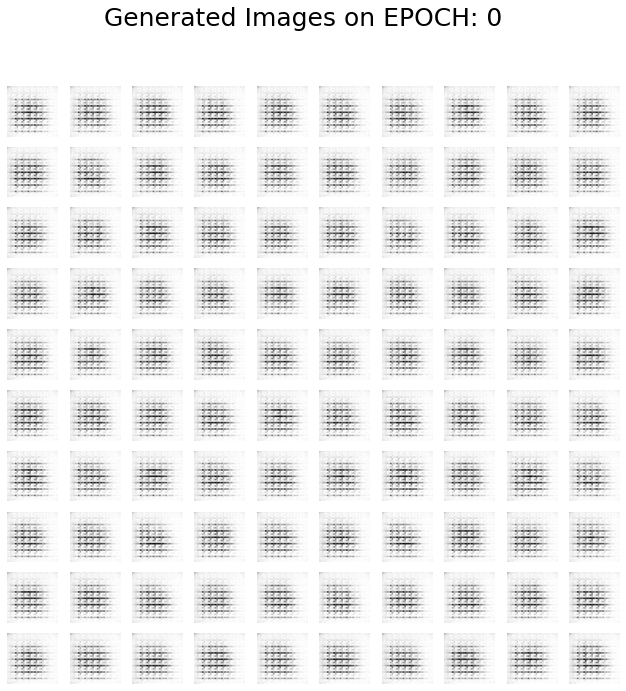

1 epochs trained
2 epochs trained
3 epochs trained
4 epochs trained
5 epochs trained
6 epochs trained
7 epochs trained
8 epochs trained
9 epochs trained
10 epochs trained


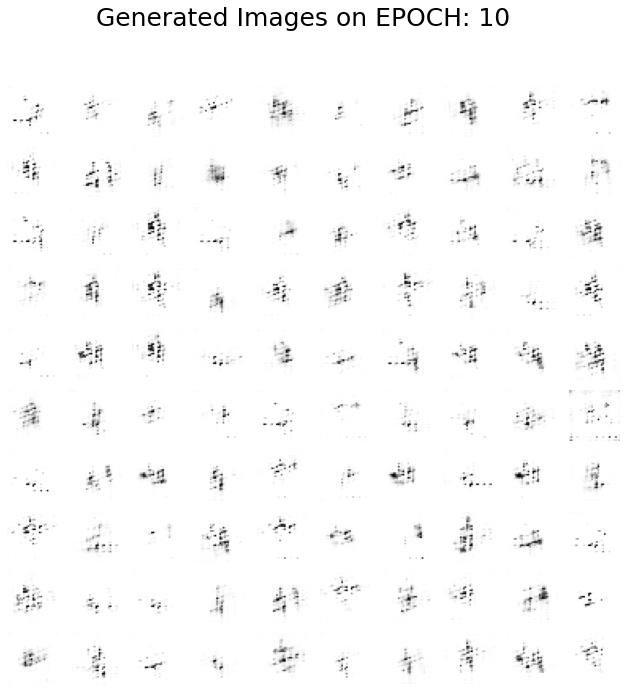

11 epochs trained
12 epochs trained
13 epochs trained
14 epochs trained
15 epochs trained
16 epochs trained
17 epochs trained
18 epochs trained
19 epochs trained
20 epochs trained


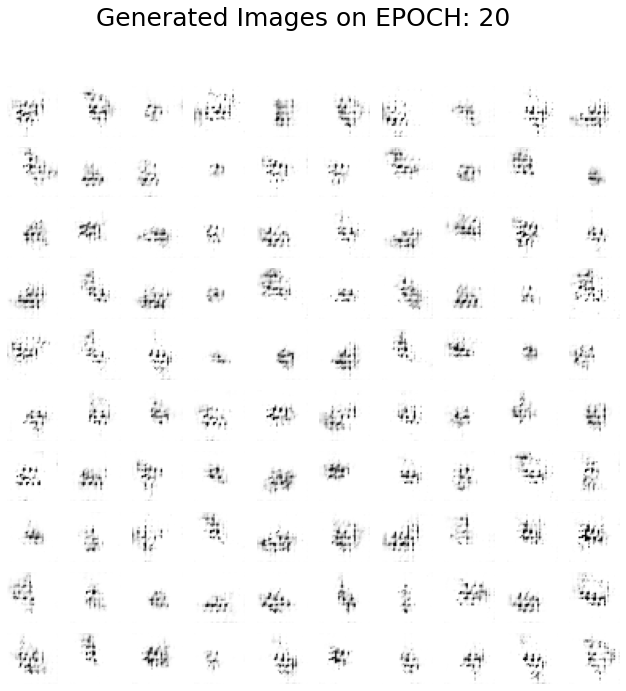

21 epochs trained
22 epochs trained
23 epochs trained
24 epochs trained
25 epochs trained
26 epochs trained
27 epochs trained
28 epochs trained
29 epochs trained
30 epochs trained


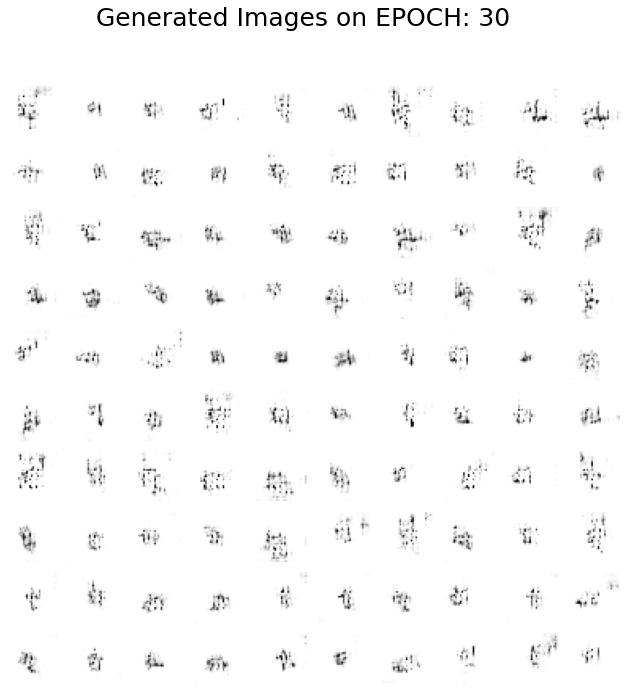

31 epochs trained
32 epochs trained
33 epochs trained
34 epochs trained
35 epochs trained
36 epochs trained
37 epochs trained
38 epochs trained
39 epochs trained
40 epochs trained


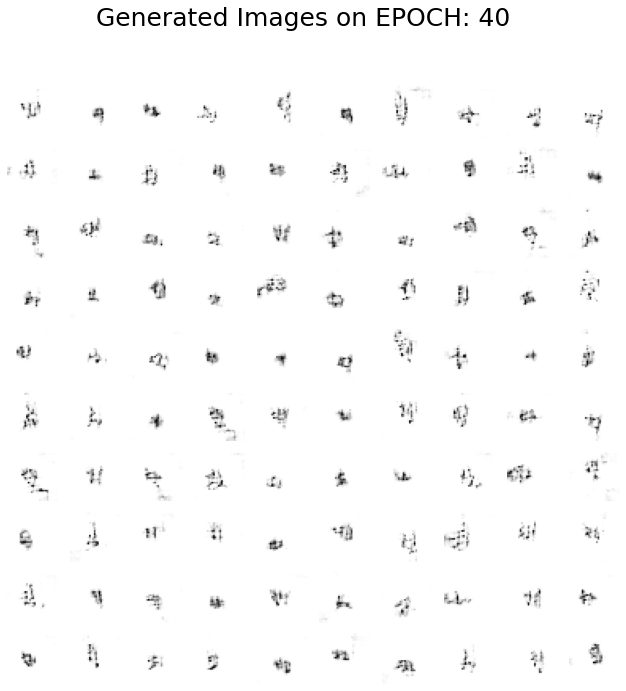

41 epochs trained
42 epochs trained
43 epochs trained
44 epochs trained
45 epochs trained
46 epochs trained
47 epochs trained
48 epochs trained
49 epochs trained
50 epochs trained


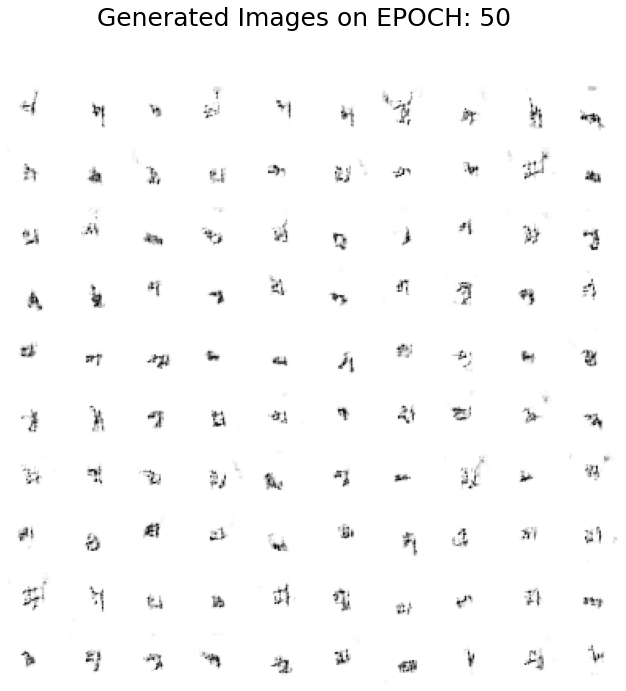

51 epochs trained
52 epochs trained
53 epochs trained
54 epochs trained
55 epochs trained
56 epochs trained
57 epochs trained
58 epochs trained
59 epochs trained
60 epochs trained


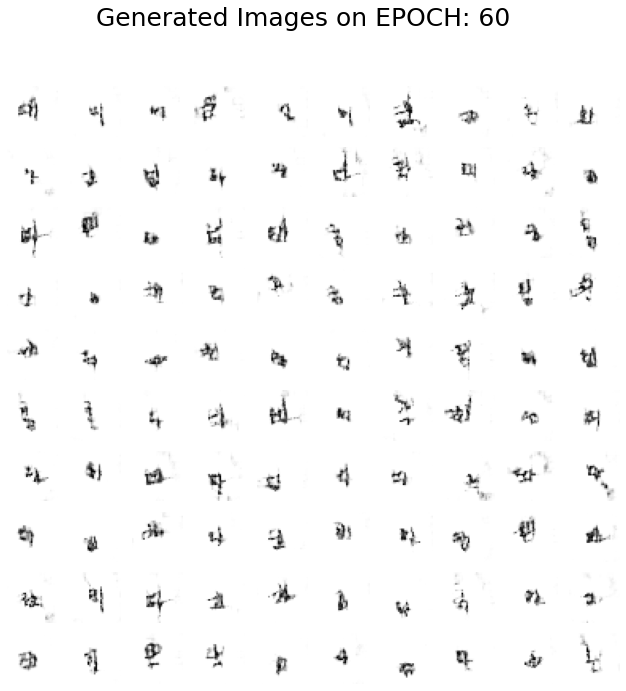

61 epochs trained
62 epochs trained
63 epochs trained
64 epochs trained
65 epochs trained
66 epochs trained
67 epochs trained
68 epochs trained
69 epochs trained
70 epochs trained


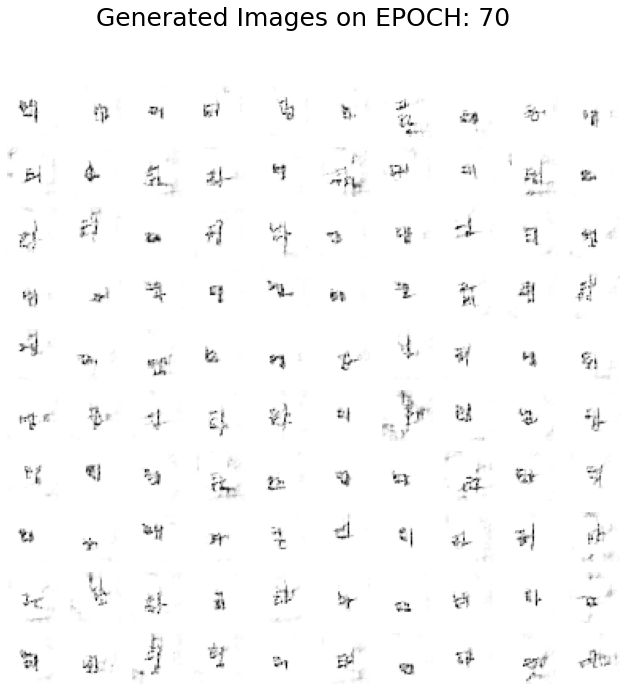

71 epochs trained
72 epochs trained
73 epochs trained
74 epochs trained
75 epochs trained
76 epochs trained
77 epochs trained
78 epochs trained
79 epochs trained
80 epochs trained


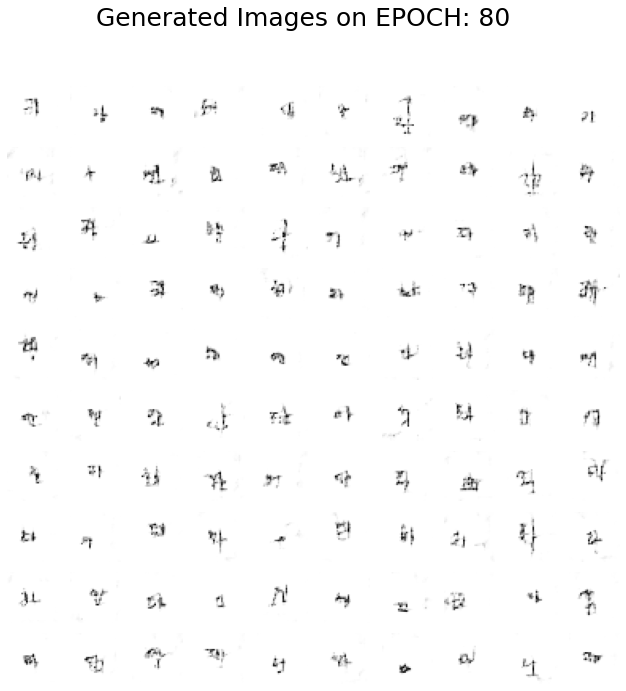

81 epochs trained
82 epochs trained
83 epochs trained
84 epochs trained
85 epochs trained
86 epochs trained
87 epochs trained
88 epochs trained
89 epochs trained
90 epochs trained


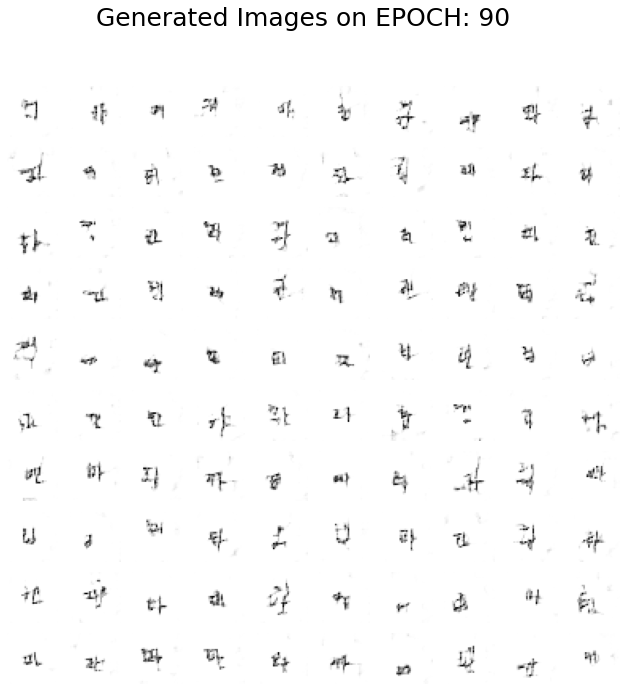

91 epochs trained
92 epochs trained
93 epochs trained
94 epochs trained
95 epochs trained
96 epochs trained
97 epochs trained
98 epochs trained
99 epochs trained
100 epochs trained


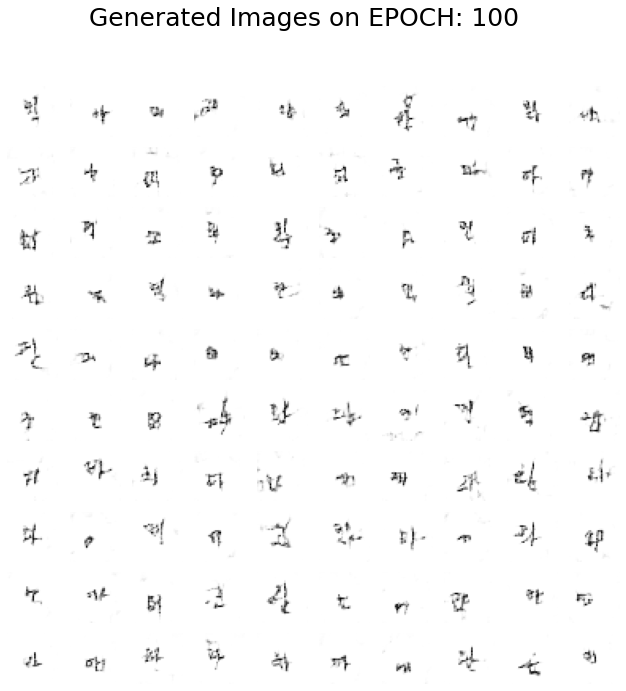

101 epochs trained
102 epochs trained
103 epochs trained
104 epochs trained
105 epochs trained
106 epochs trained
107 epochs trained
108 epochs trained
109 epochs trained
110 epochs trained


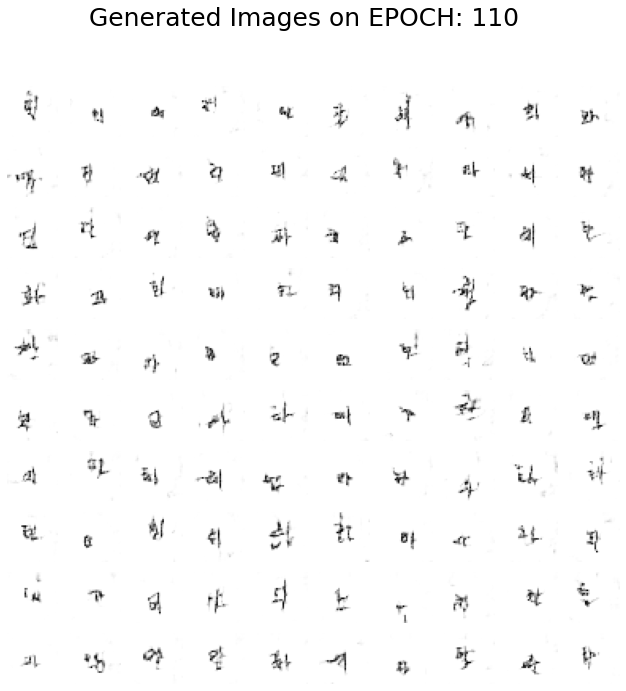

111 epochs trained
112 epochs trained
113 epochs trained
114 epochs trained
115 epochs trained
116 epochs trained
117 epochs trained
118 epochs trained
119 epochs trained
120 epochs trained


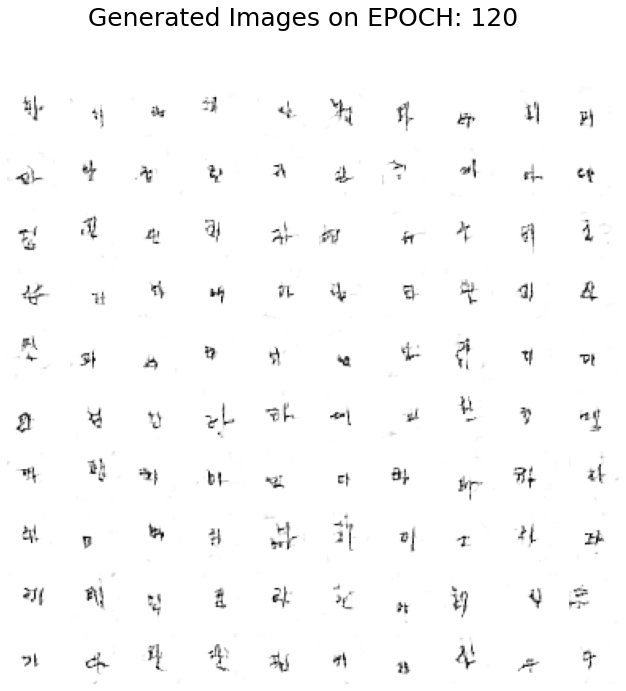

121 epochs trained
122 epochs trained
123 epochs trained
124 epochs trained
125 epochs trained
126 epochs trained
127 epochs trained
128 epochs trained
129 epochs trained
130 epochs trained


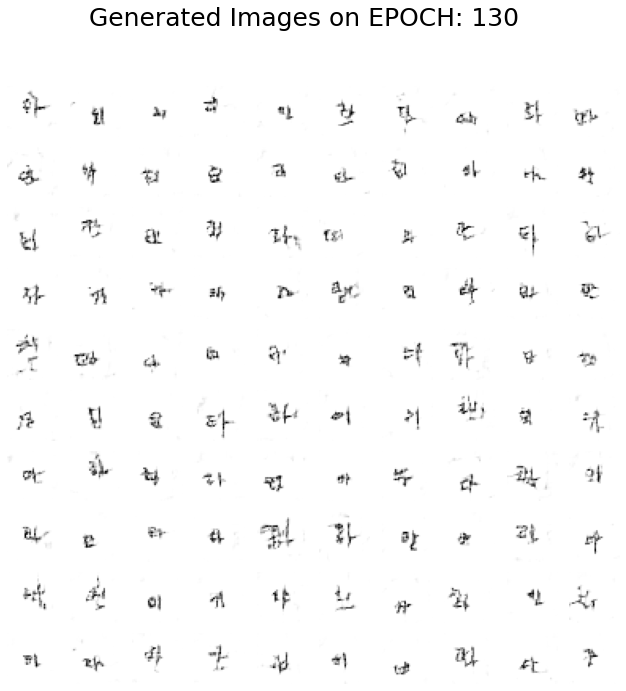

131 epochs trained
132 epochs trained
133 epochs trained
134 epochs trained
135 epochs trained
136 epochs trained
137 epochs trained
138 epochs trained
139 epochs trained
140 epochs trained


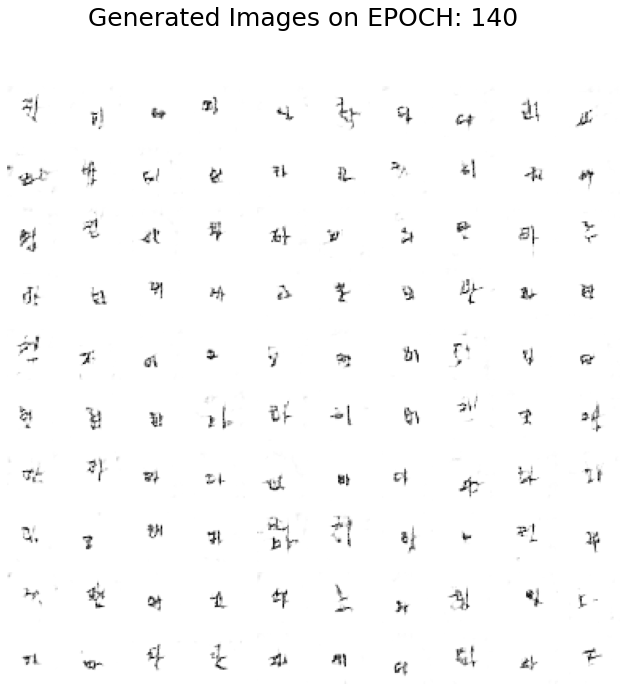

141 epochs trained
142 epochs trained
143 epochs trained
144 epochs trained
145 epochs trained
146 epochs trained
147 epochs trained
148 epochs trained
149 epochs trained
150 epochs trained


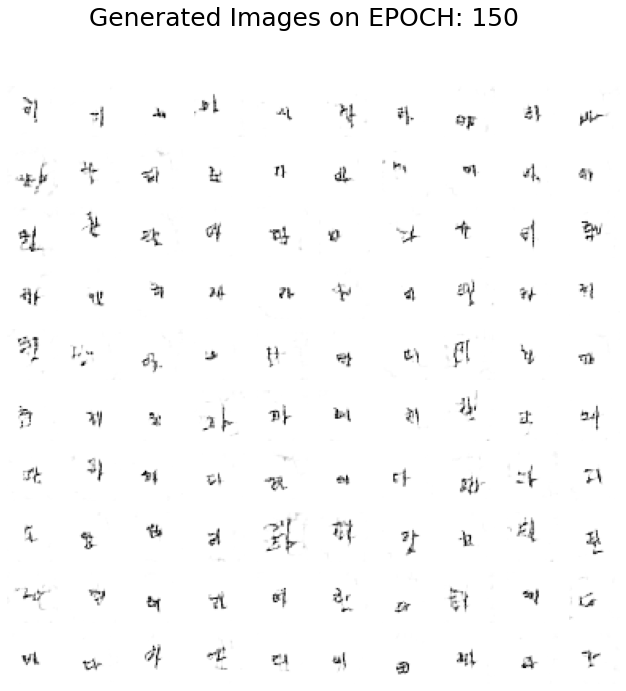

151 epochs trained
152 epochs trained
153 epochs trained
154 epochs trained
155 epochs trained
156 epochs trained
157 epochs trained
158 epochs trained
159 epochs trained
160 epochs trained


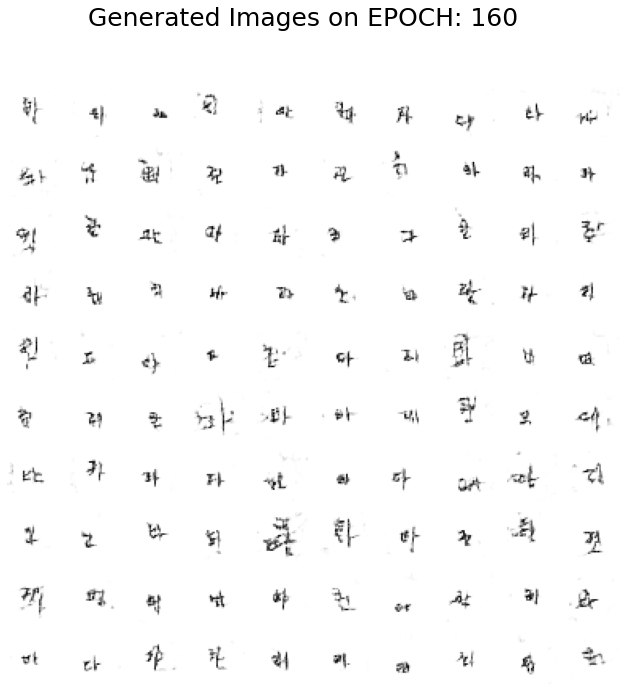

161 epochs trained
162 epochs trained
163 epochs trained
164 epochs trained
165 epochs trained
166 epochs trained
167 epochs trained
168 epochs trained
169 epochs trained
170 epochs trained


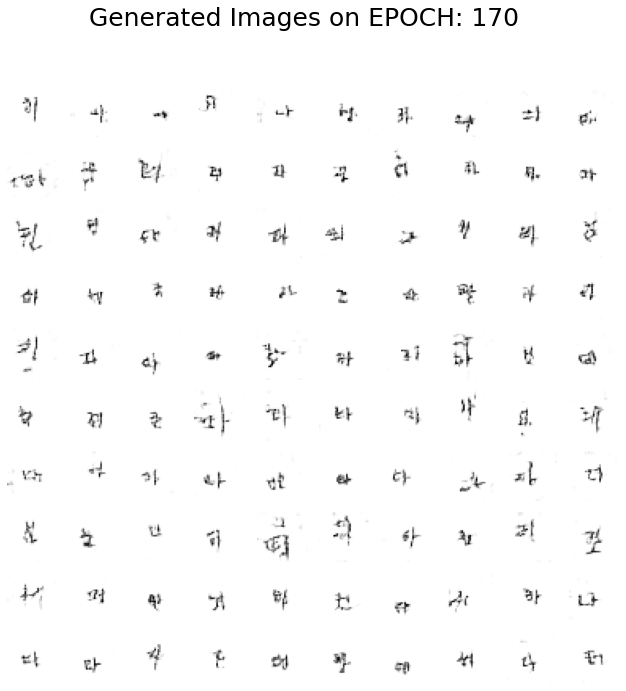

171 epochs trained
172 epochs trained
173 epochs trained
174 epochs trained
175 epochs trained
176 epochs trained
177 epochs trained
178 epochs trained
179 epochs trained
180 epochs trained


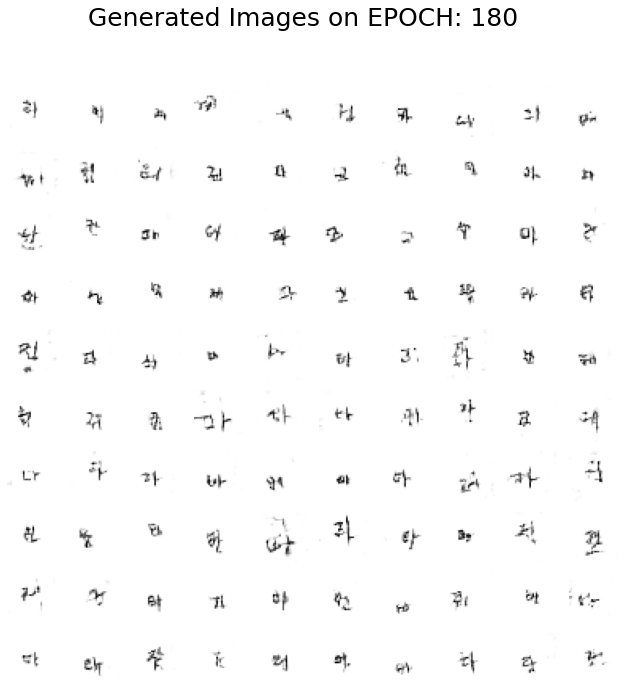

181 epochs trained
182 epochs trained
183 epochs trained
184 epochs trained
185 epochs trained
186 epochs trained
187 epochs trained
188 epochs trained
189 epochs trained
190 epochs trained


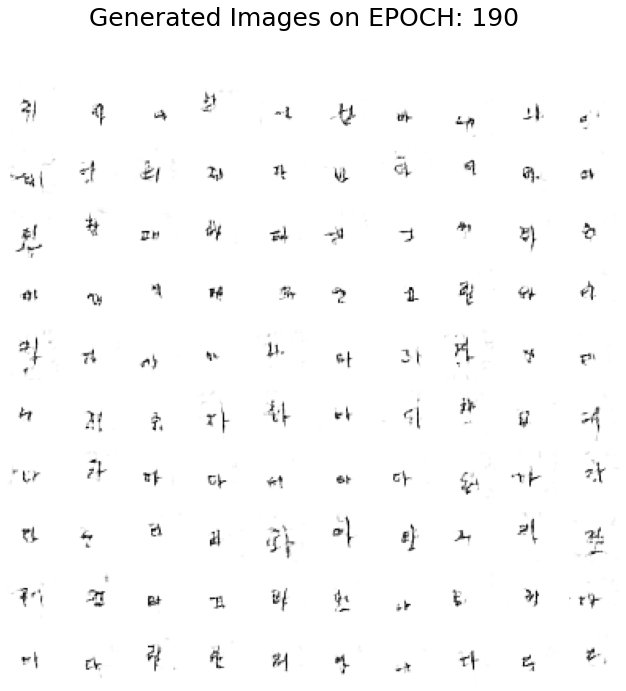

191 epochs trained
192 epochs trained
193 epochs trained
194 epochs trained
195 epochs trained
196 epochs trained
197 epochs trained
198 epochs trained
199 epochs trained
200 epochs trained


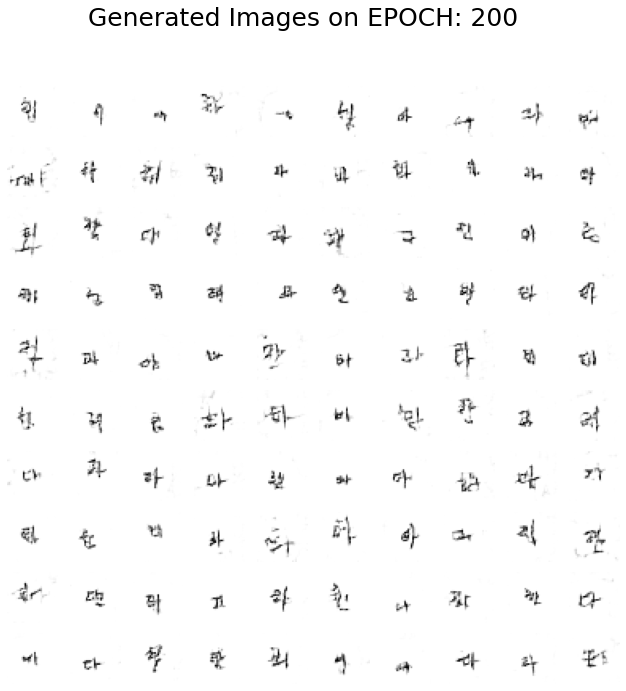

201 epochs trained
202 epochs trained
203 epochs trained
204 epochs trained
205 epochs trained
206 epochs trained
207 epochs trained
208 epochs trained
209 epochs trained
210 epochs trained


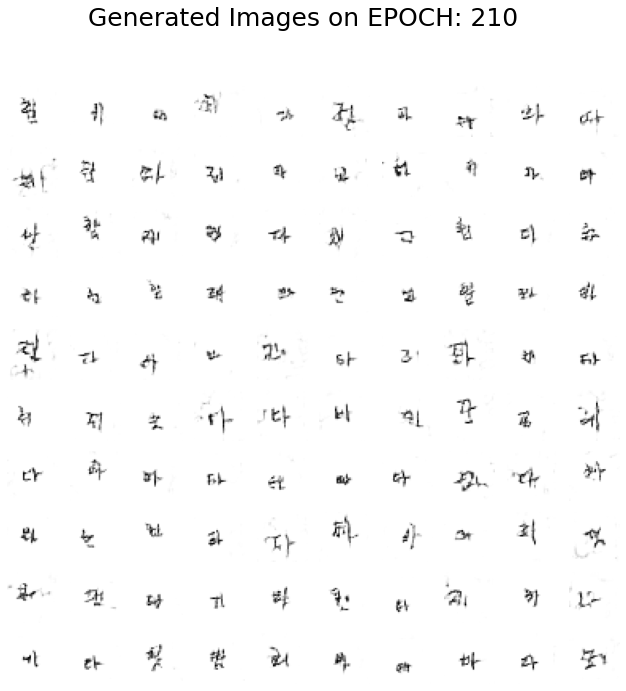

211 epochs trained
212 epochs trained
213 epochs trained
214 epochs trained
215 epochs trained
216 epochs trained
217 epochs trained
218 epochs trained
219 epochs trained
220 epochs trained


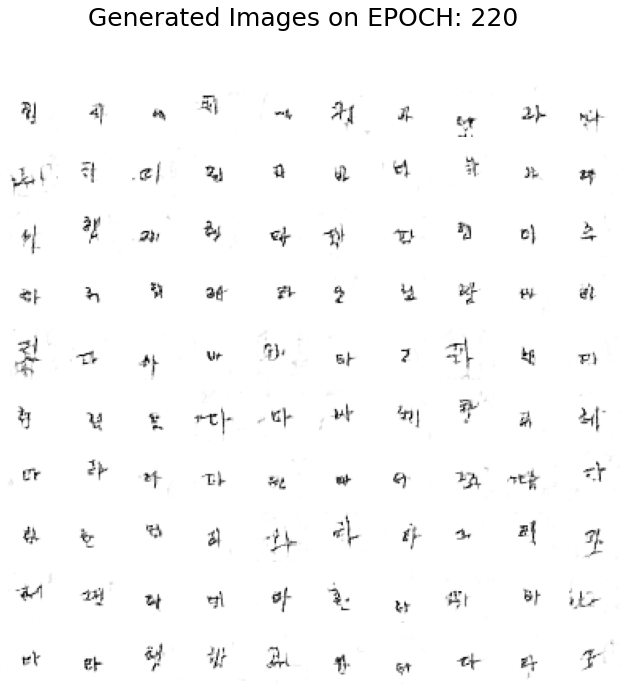

221 epochs trained
222 epochs trained
223 epochs trained
224 epochs trained
225 epochs trained
226 epochs trained
227 epochs trained
228 epochs trained
229 epochs trained
230 epochs trained


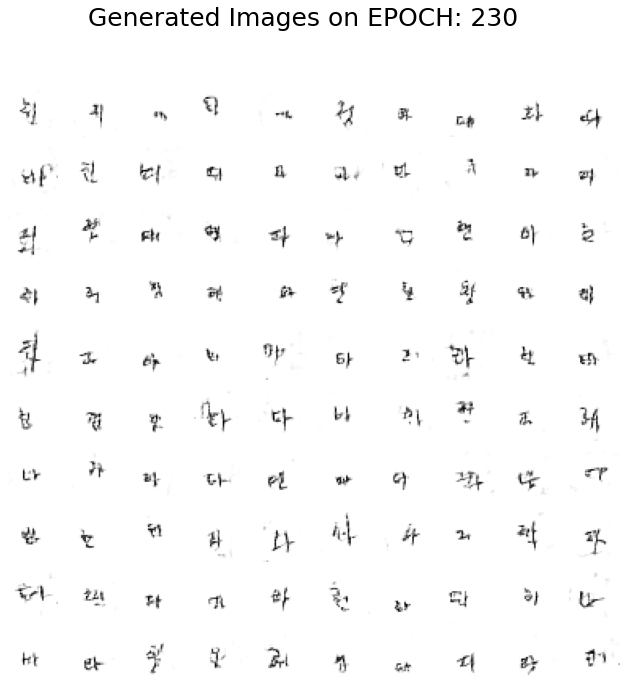

231 epochs trained
232 epochs trained
233 epochs trained
234 epochs trained
235 epochs trained
236 epochs trained
237 epochs trained
238 epochs trained
239 epochs trained
240 epochs trained


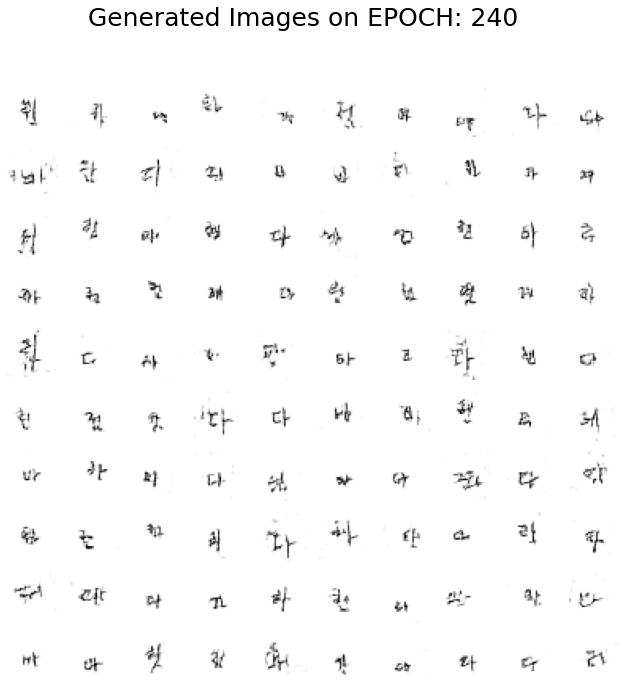

241 epochs trained
242 epochs trained
243 epochs trained
244 epochs trained
245 epochs trained
246 epochs trained
247 epochs trained
248 epochs trained
249 epochs trained
250 epochs trained


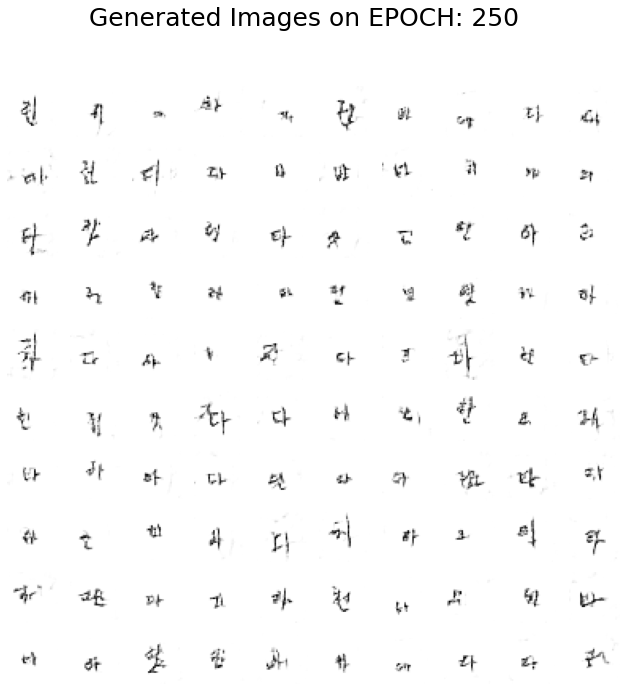

251 epochs trained
252 epochs trained
253 epochs trained
254 epochs trained
255 epochs trained
256 epochs trained
257 epochs trained
258 epochs trained
259 epochs trained
260 epochs trained


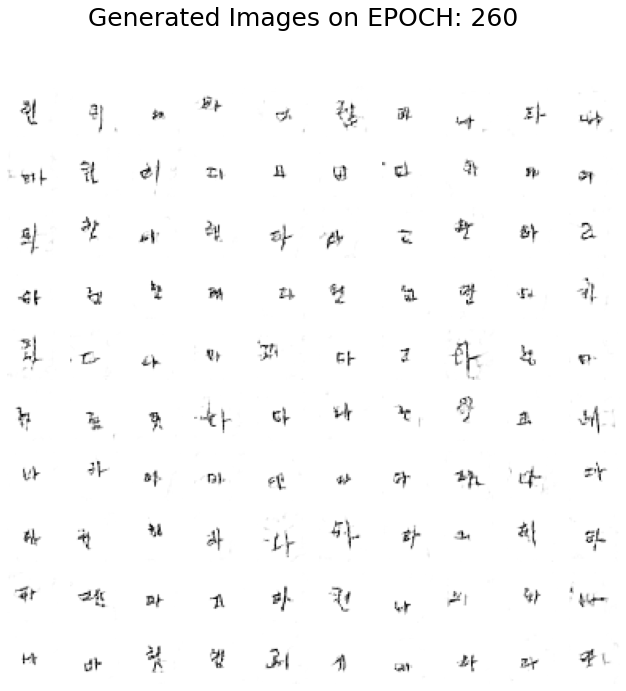

261 epochs trained
262 epochs trained
263 epochs trained
264 epochs trained
265 epochs trained
266 epochs trained
267 epochs trained
268 epochs trained
269 epochs trained
270 epochs trained


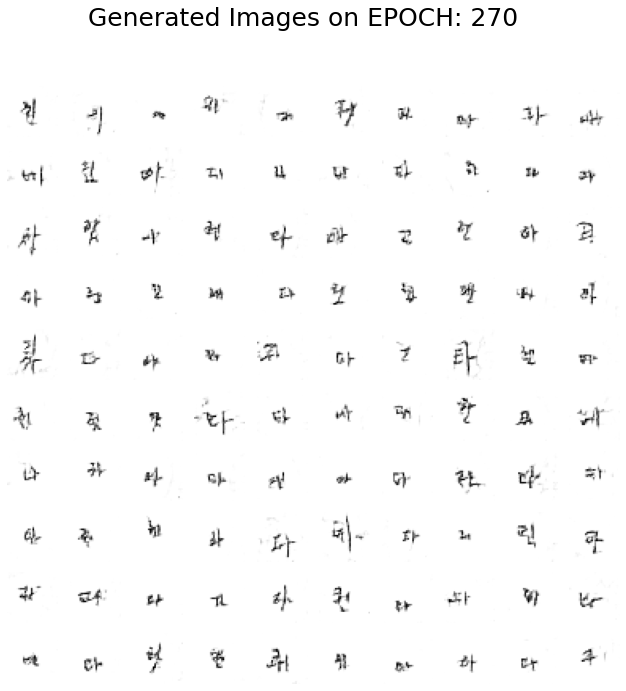

271 epochs trained
272 epochs trained
273 epochs trained
274 epochs trained
275 epochs trained
276 epochs trained
277 epochs trained
278 epochs trained
279 epochs trained
280 epochs trained


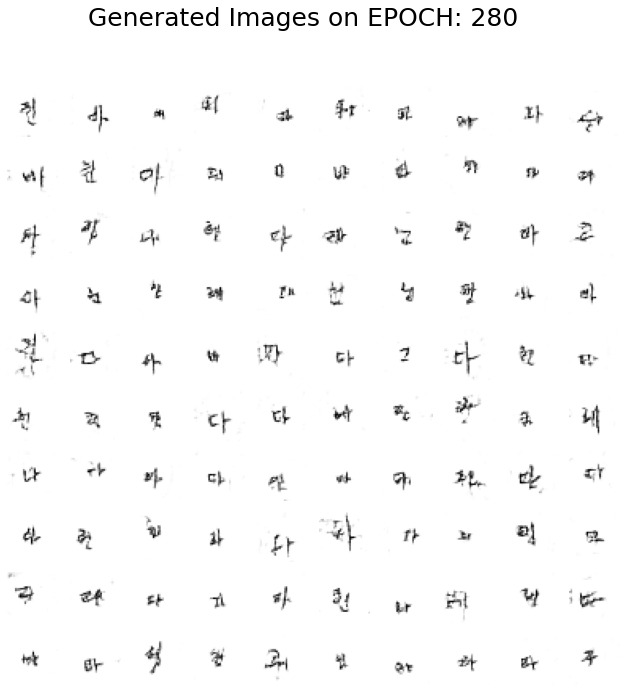

281 epochs trained
282 epochs trained
283 epochs trained
284 epochs trained
285 epochs trained
286 epochs trained
287 epochs trained
288 epochs trained
289 epochs trained
290 epochs trained


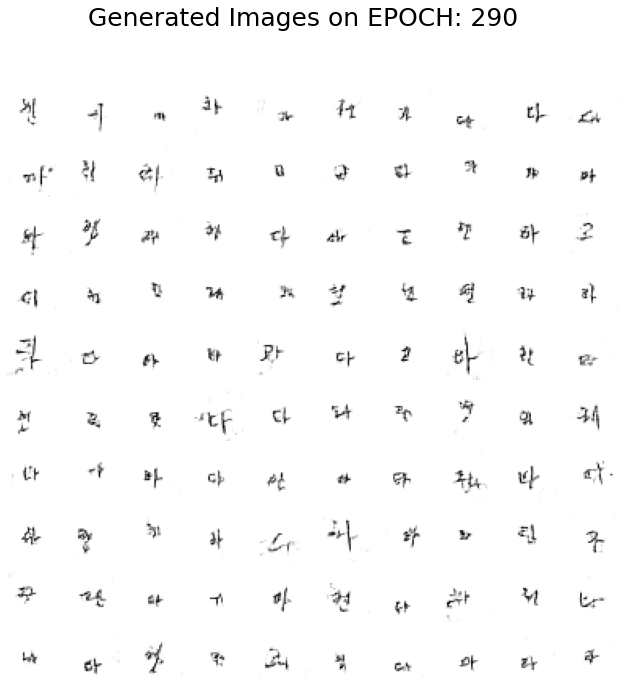

291 epochs trained
292 epochs trained
293 epochs trained
294 epochs trained
295 epochs trained
296 epochs trained
297 epochs trained
298 epochs trained
299 epochs trained
Time for epoch 300 is 3.1438558101654053 sec


In [119]:
# 6-5. 학습 시작!
%time
train(train_dataset, EPOCHS)